In [ ]:
import os
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tiingo import TiingoClient
from datetime import datetime, timedelta

# --- 1. Tiingo API Setup and Data Fetching ---

def fetch_and_analyze_news(api_key, ticker, start_date, end_date, interval_days=45):
    """
    Fetches Tiingo news data in smaller intervals to spread out the articles,
    performs VADER sentiment analysis, and aggregates the daily average sentiment score.
    """
    print(f"--- Fetching Tiingo News for {ticker} from {start_date} to {end_date} ---")

    # 1.1 Configure and Initialize Tiingo Client
    config = {'api_key': api_key}
    client = TiingoClient(config)

    all_articles = []

    # 1.2 Split the time range into intervals
    current_start = datetime.strptime(start_date, '%Y-%m-%d')
    current_end = min(current_start + timedelta(days=interval_days - 1), datetime.strptime(end_date, '%Y-%m-%d'))

    while current_start <= datetime.strptime(end_date, '%Y-%m-%d'):
        print(f"Fetching articles from {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}...")

        try:
            # Fetch news articles for the current interval
            articles = client.get_news(
                tickers=[ticker],
                startDate=current_start.strftime('%Y-%m-%d'),
                endDate=current_end.strftime('%Y-%m-%d'),
                limit=1000  # Tiingo's max limit per request
            )
            all_articles.extend(articles)

        except Exception as e:
            print(f"Error fetching data from Tiingo for {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}: {e}")

        # Move to the next interval
        current_start = current_end + timedelta(days=1)
        current_end = min(current_start + timedelta(days=interval_days - 1), datetime.strptime(end_date, '%Y-%m-%d'))

    if not all_articles:
        print(f"No articles found for {ticker} in the specified range.")
        return pd.DataFrame()

    # 1.3 Convert to DataFrame and Pre-process
    news_df = pd.DataFrame(all_articles)

    # Remove duplicates based on 'title' and 'description'
    news_df = news_df.drop_duplicates(subset=['title', 'description'], keep='first')
    
    news_df['date'] = pd.to_datetime(news_df['publishedDate'], format='ISO8601').dt.date
    news_df['text_to_analyze'] = news_df['title'].fillna('') + ' ' + news_df['description'].fillna('')
    print(news_df[['date', 'title', 'description']])
    news_df.to_csv('fetched_news.csv', index=False)

    print(f"Successfully fetched {len(news_df)} articles.")

    # --- 2. Sentiment Analysis with VADER ---
    try:
        nltk.data.find('sentiment/vader_lexicon.zip')
    except nltk.downloader.DownloadError:
        print("Downloading NLTK VADER lexicon...")
        nltk.download('vader_lexicon')

    sid = SentimentIntensityAnalyzer()

    def get_vader_score(text):
        """Returns the compound score from VADER analysis."""
        return sid.polarity_scores(text)['compound']

    news_df['sentiment_score'] = news_df['text_to_analyze'].apply(get_vader_score)

    # --- 3. Aggregate Daily Sentiment ---
    daily_sentiment = news_df.groupby('date')['sentiment_score'].mean().reset_index()
    daily_sentiment.columns = ['Date', 'Avg_Sentiment']
    daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

    return daily_sentiment

def fetch_stock_prices(api_key, ticker, start_date, end_date):
    """
    Fetches historical End-of-Day (EOD) stock prices using Tiingo. 
    Renames Tiingo's lowercase columns to the traditional capitalized format.
    """
    print(f"--- Fetching Market Data for {ticker} from Tiingo ---")
    
    config = {'api_key': api_key}
    client = TiingoClient(config)

    try:
        # Fetch EOD data (frequency='daily') as a Pandas DataFrame
        stock_df = client.get_dataframe(
            ticker, 
            frequency='daily', 
            startDate=start_date, 
            endDate=end_date
        )
        
        # Tiingo's get_dataframe returns 'date' as the index. Reset index.
        stock_df.reset_index(inplace=True)
        
        # --- FIX: Rename all Tiingo lowercase columns to expected capitalized format ---
        stock_df.rename(columns={
            'date': 'Date',          
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
            'adjOpen': 'Adj Open',
            'adjHigh': 'Adj High',
            'adjLow': 'Adj Low',
            'adjClose': 'Adj Close', 
            'volume': 'Volume',
            'adjVolume': 'Adj Volume',
        }, inplace=True)

        # Ensure the 'Date' column is converted to timezone-naive datetime objects
        # This is the fix for the TZ-aware error.
        stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.tz_localize(None)

        # Return the essential columns. Now, 'Open', 'High', etc., are guaranteed to exist.
        return stock_df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

    except Exception as e:
        # Catches API connection errors or other unexpected issues
        print(f"Error fetching stock prices from Tiingo: {e}")
        return pd.DataFrame()



In [55]:
# --- Configuration ---
# !! IMPORTANT: Replace this with your actual Tiingo API Key !!
TIINGO_API_KEY = os.getenv('TIINGO_API_KEY', None) 

TICKER = 'AAPL'
DAYS_TO_FETCH = 1000
END_DATE = datetime.now().strftime('%Y-%m-%d')
START_DATE = (datetime.now() - timedelta(days=DAYS_TO_FETCH)).strftime('%Y-%m-%d')
# ---------------------

--- Fetching Tiingo News for AAPL from 2023-03-12 to 2025-12-06 ---
Fetching articles from 2023-03-12 to 2023-04-10...
Fetching articles from 2023-04-11 to 2023-05-10...
Fetching articles from 2023-05-11 to 2023-06-09...
Fetching articles from 2023-06-10 to 2023-07-09...
Fetching articles from 2023-07-10 to 2023-08-08...
Fetching articles from 2023-08-09 to 2023-09-07...
Fetching articles from 2023-09-08 to 2023-10-07...
Fetching articles from 2023-10-08 to 2023-11-06...
Fetching articles from 2023-11-07 to 2023-12-06...
Fetching articles from 2023-12-07 to 2024-01-05...
Fetching articles from 2024-01-06 to 2024-02-04...
Fetching articles from 2024-02-05 to 2024-03-05...
Fetching articles from 2024-03-06 to 2024-04-04...
Fetching articles from 2024-04-05 to 2024-05-04...
Fetching articles from 2024-05-05 to 2024-06-03...
Fetching articles from 2024-06-04 to 2024-07-03...
Fetching articles from 2024-07-04 to 2024-08-02...
Fetching articles from 2024-08-03 to 2024-09-01...
Fetching artic

C:\Users\sar81\AppData\Local\Temp\ipykernel_25200\4134266961.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df['Avg_Sentiment'] = final_df['Avg_Sentiment'].fillna(method='ffill')


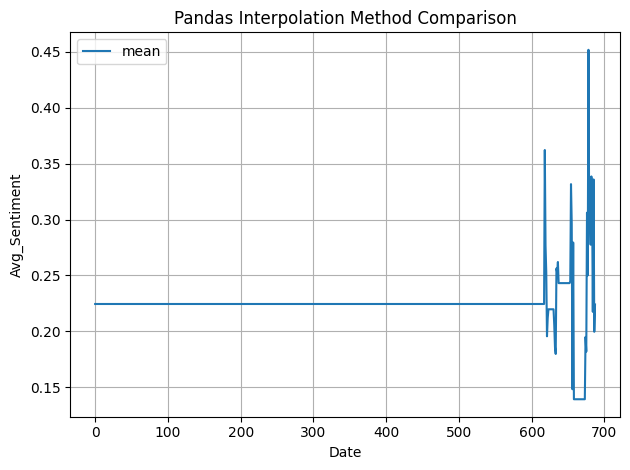

In [57]:
# 1. Get News Sentiment Feature
sentiment_df = fetch_and_analyze_news(TIINGO_API_KEY, TICKER, START_DATE, END_DATE)

if sentiment_df.empty:
    print("Sentiment analysis failed or returned no data. Exiting.")
else:
    # Check for data sparsity which causes the all-zero issue
    if len(sentiment_df) < (DAYS_TO_FETCH * 0.1): # If less than 10% of days have sentiment
            print(f"\n! WARNING: Only {len(sentiment_df)} unique days of sentiment data were returned by Tiingo.")
            print("This may be due to API limits. Proceeding with imputation.")


# 2. Get Historical Price Data (EOD prices) from Tiingo
price_df = fetch_stock_prices(TIINGO_API_KEY, TICKER, START_DATE, END_DATE)

if price_df.empty:
        print("Price data fetch failed or returned no data. Exiting.")
else:
    # 3. Merge the DataFrames
    # Align the daily sentiment score with the corresponding day's OHLC data.
    final_df = pd.merge(price_df, sentiment_df, on='Date', how='left')
    
    # --- 4. Handle Missing Sentiment (Days with no news or non-trading days) ---
    
    # 4a. Forward Fill (FFILL): Carry the last known sentiment score forward to the next trading days.
    # This handles gaps *between* known data points (e.g., weekends).
    final_df['Avg_Sentiment'] = final_df['Avg_Sentiment'].fillna(method='ffill')

    # 4c. Mean Interpolation: Fill any remaining gaps with the mean as a baseline sentiment
    avg_sentiment = final_df['Avg_Sentiment'].mean()
    final_df['Avg_Sentiment'] = final_df['Avg_Sentiment'].fillna(avg_sentiment)

    # 4d. Final Fallback: Fill any remaining NaNs (if the entire column was empty or a single leading NaN wasn't caught) with 0.0.
    final_df['Avg_Sentiment'] = final_df['Avg_Sentiment'].fillna(0.0)
            

In [58]:
final_df

,Date,Open,High,Low,Close,Adj Close,Volume,Avg_Sentiment
0,2023-03-13,147.805,153.140,147.7000,150.47,148.474799,84457122,0.224375
1,2023-03-14,151.280,153.400,150.1000,152.59,150.566688,73695893,0.224375
2,2023-03-15,151.190,153.245,149.9200,152.99,150.961384,77167866,0.224375
3,2023-03-16,152.160,156.460,151.6400,155.85,153.783461,76254419,0.224375
4,2023-03-17,156.080,156.740,154.2800,155.00,152.944732,98944633,0.224375
...,...,...,...,...,...,...,...,...
683,2025-12-01,278.010,283.420,276.1400,283.10,283.100000,46587722,0.315659
684,2025-12-02,283.000,287.400,282.6301,286.19,286.190000,53669532,0.217367
685,2025-12-03,286.200,288.620,283.3000,284.15,284.150000,43538687,0.335866
686,2025-12-04,284.095,284.730,278.5900,280.70,280.700000,43989056,0.199478
